In [1]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install jupyterlab
!pip install pillow
!pip install scipy
!pip install implicit
!pip install sentence_transformers
!pip install pydot graphviz


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip



In [2]:
import pandas as pd
dummy_df_df = pd.read_csv('GrammarandProductReviews.csv')
dummy_df_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  str    
 1   brand                 71044 non-null  str    
 2   categories            71044 non-null  str    
 3   dateAdded             71044 non-null  str    
 4   dateUpdated           71044 non-null  str    
 5   ean                   39065 non-null  str    
 6   keys                  71044 non-null  str    
 7   manufacturer          70903 non-null  str    
 8   manufacturerNumber    70841 non-null  str    
 9   name                  71044 non-null  str    
 10  reviews.date          70977 non-null  str    
 11  reviews.dateAdded     71044 non-null  str    
 12  reviews.dateSeen      71044 non-null  str    
 13  reviews.didPurchase   32158 non-null  object 
 14  reviews.doRecommend   60429 non-null  object 
 15  reviews.id            32158 no

In [3]:
dummy_df_df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


<Axes: >

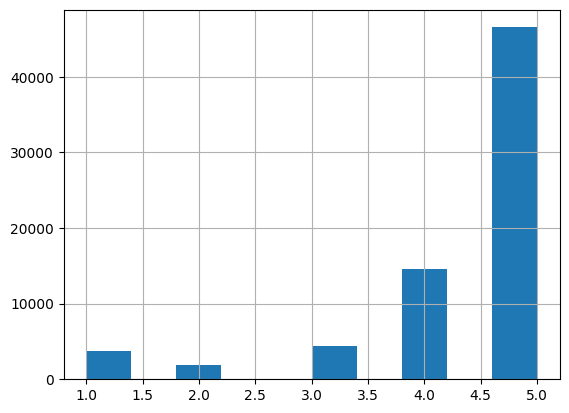

In [4]:
dummy_df_df['reviews.rating'].hist()

In [5]:
dummy_df_df['reviews.username'].value_counts().describe()

count    58087.000000
mean         1.221306
std          2.152767
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        421.000000
Name: count, dtype: float64

In [6]:
pip install nvidia-cuda-nvcc-cu12


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tf.config.optimizer.set_jit(False)  # Disable XLA.

2026-02-14 06:55:50.722339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-14 06:55:51.519067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-14 06:55:54.195743: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
df = pd.read_csv(r'GrammarandProductReviews.csv')
df

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71039,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,6855681.0,6.0,5,https://www.walmart.com/reviews/product/10294231,I'm dealing with dry eyes and very sensitive t...,Solves the problem,NaN,NaN,Seniorgal,"300650361040,631113253665,300650193108,3006503..."
71040,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,71102868.0,1.0,5,https://www.walmart.com/reviews/product/10294231,Great stuff! Helps keep my contacts moist all ...,Great stuff!,NaN,NaN,Nammaw,"300650361040,631113253665,300650193108,3006503..."
71041,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,58039428.0,0.0,5,https://www.walmart.com/reviews/product/10294231,Right price,My review,NaN,NaN,LDBoston,"300650361040,631113253665,300650193108,3006503..."
71042,AVzvTLfivKc47QAVfPme,Bebe Au Lait,"Baby,Nursing & Feeding,Breastfeeding,Nursing C...",2017-06-28T15:23:21Z,2018-02-05T10:19:41Z,8.78982E+11,"878982005883,bebeaulait/50032623,08789820

In [9]:
df['reviews.title'] = df['reviews.title'].fillna('No Title') # fills empty titles
df['reviews.text'] = df['reviews.text'].fillna('No Review')
df['reviews.username'] = df['reviews.username'].fillna('Akshat') # Can also assign it as anonymous user but for sake of info i'll pretend i bought these products
df['manufacturer'] = df['manufacturer'].fillna(df['manufacturer'].mode()) # most occuring manufacturer

In [10]:
user_map = {u: i for i, u in enumerate(df['reviews.username'].unique())}
item_map = {i: j for j, i in enumerate(df['id'].unique())}

In [11]:
df['user_id'] = df['reviews.username'].map(user_map)
df['prod_id'] = df['id'].map(item_map)
df['reviews.rating'] = df['reviews.rating'].astype(np.float32)

In [12]:
"""  Negative Upsampling through normalized scores (alpha = 0.75) """
alpha_weight = 1.0
weighted_sum = (df['prod_id'].value_counts())**(alpha_weight)
normalized_prod_id = weighted_sum / weighted_sum.sum()
normalized_prod_id = normalized_prod_id.sort_index()
normalized_prod_id

prod_id
0      0.000014
1      0.000028
2      0.000380
3      0.000084
4      0.000056
         ...   
595    0.000056
596    0.007911
597    0.003153
598    0.000014
599    0.000014
Name: count, Length: 600, dtype: float64

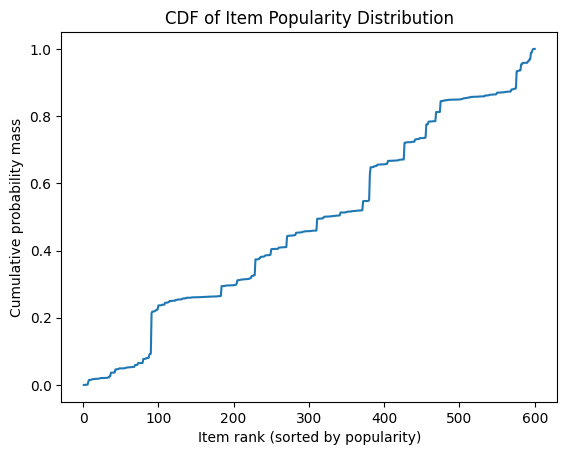

In [13]:
cdf = np.cumsum(normalized_prod_id)
plt.figure()
plt.plot(np.arange(1, len(cdf) + 1), cdf)
plt.xlabel("Item rank (sorted by popularity)")
plt.ylabel("Cumulative probability mass")
plt.title("CDF of Item Popularity Distribution")
plt.show()

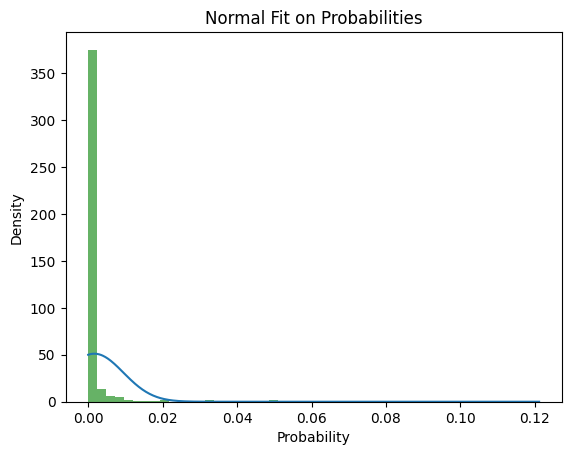

In [14]:
# ---- 3. Histogram of log-probabilities ----
from scipy.stats import norm
# eps = 1e-12
# log_probs = np.log(normalized_prod_id + eps)

# plt.figure()
# plt.hist(log_probs, bins=50, density=True)
# plt.xlabel("log(Probability)")
# plt.ylabel("Density")
# plt.title("Histogram of Log-Transformed Probabilities")
# plt.show()

# ---- 4. Normal (bell curve) fit on log-probabilities ----
mu, sigma = normalized_prod_id.mean(), normalized_prod_id.std()
x = np.linspace(normalized_prod_id.min(), normalized_prod_id.max(), 500)
pdf = norm.pdf(x, mu, sigma)

plt.figure()
plt.hist(normalized_prod_id,bins = 50, density=True, alpha=0.6, color='g')
plt.plot(x, pdf)
plt.xlabel("Probability")
plt.ylabel("Density")
plt.title("Normal Fit on Probabilities")
plt.show()

In [15]:
def generate_negative_prod_id_and_rating(normalized_prod_id):
    """Generates one prod id using label smoothning and its negative rating"""
    negative_prod_id = np.random.choice(np.arange(0,600), p = normalized_prod_id) # samples a negative value based on popularity label smoothed
    negative_rating_of_prod_id = np.random.uniform(0,2)
    return (negative_prod_id,negative_rating_of_prod_id)

In [16]:
product_lookup = (
    df
    .drop_duplicates(subset="prod_id")
    .set_index("prod_id")
)

In [17]:
""" Inserts k negative samples per record in the dataframe"""
rows = []
k = 3

for record in df.itertuples(index=False):
    curr_prod_id = record.prod_id

    for _ in range(k):
        while True:
            neg_prod_id, neg_rating = generate_negative_prod_id_and_rating(normalized_prod_id)
            if neg_prod_id != curr_prod_id: # Continue regenrating until we get a negative sample which is not the same as the positive one
                break

        # copy full product metadata
        prod_row = product_lookup.loc[neg_prod_id].to_dict()

        prod_row.update({
            "user_id": record.user_id,
            "reviews.rating": neg_rating,
            "is_negative": True
        })

        rows.append(prod_row)

negative_samples_df = pd.DataFrame(rows)
negative_samples_df.to_csv("negative_samples.csv", index=False)
negative_samples_df.shape

(213132, 27)

In [18]:
df = df.copy()
df['is_negative'] = False

final_df = pd.concat(
    [df, negative_samples_df],
    ignore_index=True
)
final_df = final_df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe
final_df['prod_id'] = final_df['id'].map(item_map)
final_df.shape

(284176, 28)

In [19]:
final_df.to_csv("final_df.csv", index=False)
df = final_df.copy()
df.shape

(284176, 28)

In [20]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 284176 entries, 0 to 284175
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    284176 non-null  str    
 1   brand                 284176 non-null  str    
 2   categories            284176 non-null  str    
 3   dateAdded             284176 non-null  str    
 4   dateUpdated           284176 non-null  str    
 5   ean                   156043 non-null  str    
 6   keys                  284176 non-null  str    
 7   manufacturer          283577 non-null  str    
 8   manufacturerNumber    283369 non-null  str    
 9   name                  284176 non-null  str    
 10  reviews.date          283910 non-null  str    
 11  reviews.dateAdded     284176 non-null  str    
 12  reviews.dateSeen      284176 non-null  str    
 13  reviews.didPurchase   85119 non-null   object 
 14  reviews.doRecommend   201793 non-null  object 
 15  reviews.id 

In [21]:
df[df['reviews.username'].isna()]['reviews.username']

Series([], Name: reviews.username, dtype: str)

In [22]:
df['reviews.username'].value_counts()

reviews.username
Barsea              23212
Alas                15919
Benandjerry         10695
Debbrink            10396
primoconcept         9980
                    ...  
christinamarie42        1
Afox0514                1
Kbryn08                 1
Energizeme              1
afwifey2003             1
Name: count, Length: 58088, dtype: int64

In [23]:
""" Get only those users who have given atleast 5 reviews"""
user_review_counts = df['reviews.username'].value_counts()
active_users = user_review_counts[user_review_counts >= 2].index
filtered_df = df[df['reviews.username'].isin(active_users)]
filtered_df['reviews.username'].value_counts()

reviews.username
Barsea            23212
Alas              15919
Benandjerry       10695
Debbrink          10396
primoconcept       9980
                  ...  
Horatio99             2
Charlobby             2
Loretta11111          2
Diego                 2
Bencosmefamily        2
Name: count, Length: 7491, dtype: int64

In [24]:
df['reviews.username'].unique()

<StringArray>
[        'DixieLee',           'Barsea',         'mtellin2',
        'LoveCocoa',           'keira1',       'aeking2015',
             'Bopi',     'randimariiee',          'Shopper',
             'MIne',
 ...
            'slick',         'Missluci',            'Cdc58',
            'Devan',             'ROME', 'christinamarie42',
         'Afox0514',          'Kbryn08',       'Energizeme',
      'afwifey2003']
Length: 58088, dtype: str

In [25]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc',
       'user_id', 'prod_id', 'is_negative'],
      dtype='str')

In [26]:
# from sklearn.preprocessing import LabelEncoder

# l_encode = LabelEncoder()
# df['user_id'] = l_encode.fit_transform(df['reviews.username']) # gives each user a user_id

In [27]:
df['reviews.rating'].dtype

dtype('float64')

In [28]:
final_df['reviews.rating'].describe()

count    284176.000000
mean          1.847392
std           1.638007
min           0.000004
25%           0.668083
50%           1.300720
75%           1.966806
max           5.000000
Name: reviews.rating, dtype: float64

In [29]:
6.657402e-01

0.6657402

In [30]:
""" Below 2 cells are for experiemntation"""

import pandas as pd

# Create a dictionary of data
data = {
    'Name': ['Alice', 'Bob', 'Charlie', 'David'],
    'Age': [25, 30, 35, 40],
    'City': ['New York', 'Los Angeles', 'Chicago', 'Houston']
}

dummy_df = pd.DataFrame(data)
dummy_df


,Name,Age,City
0,Alice,25,New York
1,Bob,30,Los Angeles
2,Charlie,35,Chicago
3,David,40,Houston


In [31]:
dummy_df.loc[0] = {'Name':'Akshat', 'Age' : 21, 'City' : 'Sonipat'} # experimenting for adding new values per row
dummy_df

,Name,Age,City
0,Akshat,21,Sonipat
1,Bob,30,Los Angeles
2,Charlie,35,Chicago
3,David,40,Houston


In [32]:
df['prod_id'].value_counts().describe()

count      600.000000
mean       473.626667
std       2145.255301
min          1.000000
25%          8.000000
50%         30.500000
75%        126.250000
max      31817.000000
Name: count, dtype: float64

In [33]:
df.tail()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc,user_id,prod_id,is_negative
284171,AVpfD9xTLJeJML431ig2,FOX,"Movies, Music & Books,Movies,Comedy,Movies & T...",2015-11-09T12:47:55Z,2018-02-05T08:36:37Z,24543168676,"024543168676,fox/52208192,theressomethingabout...",20th Century Fox,52208192,There's Something About Mary (dvd),...,http://reviews.bestbuy.com/3545/5364679/review...,'Something About Mary' is a funny film. Unfort...,Picture Format is Not Theatrically Accurate,NaN,NaN,kevman79,24543168676,11544,136,True
284172,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",2016-07-26T21:32:40Z,2018-02-05T10:22:44Z,NaN,"warnerhomevideo/15773884,883929388448,godzilla...",Test,15773884,Godzilla 3d Includes Digital Copy Ultraviolet ...,...,http://reviews.bestbuy.com/3545/6435036/review...,could have left this one on the shelf but it h...,awful,NaN,NaN,primoconcept,8.83929E+11,33575,228,True
284173,AVphhorJilAPnD_x6cs7,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",2017-01-27T22:23:45Z,2018-02-05T11:28:34Z,"7,815,492,356,020,070,000,000,000","781549235602,075609194276,olay/7560919427,olay...","PROCTER & GAMBLE COMPANY, THE",7560919427,"Olay Total Effects Daily Moisturizer, 7-In-1 A...",...,https://www.walmart.com/reviews/product/484527...,I pretty saddened by this product. I've used t...,I was really not impressed,NaN,NaN,aeking2015,"781,549,235,602,075,000,000,000",8635,455,True
284174,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",2015-09-11T18:17:13Z,2018-02-05T08:35:02Z,44600015996,"clorox/12992356,044600015996,cloroxdisinfectin...",Clorox,12992356,Clorox Disinfecting Wipes Value Pack Scented 1...,...,https://redsky.target.com/groot-domain-api/v1/...,"This is an outstanding product, it not only cl...",Fresh Smell,NaN,NaN,Barsea,44600015996,31403,90,True
284175,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",2016-04-06T12:31:21Z,2018-02-05T11:26:19Z,44600080338,"044600080338,cloroxdisinfectingbathroomcleaner...",AmazonUs/CLOO7,13028043,Clorox Disinfecting Bathroom Cleaner,...,https://redsky.target.com/groot-domain-api/v1/...,I'm disappointed Clorox Bathroom Spray doesn't...,Clorox Bathroom Spray,NaN,NaN,Wkbu,"44,600,080,338,044,600,000,000",53376,183,True


In [34]:
len(df)

284176

In [35]:
df['prod_id'].value_counts()

prod_id
90     31817
380    21428
575    14303
426    13893
228    13307
       ...  
576        1
569        1
599        1
344        1
551        1
Name: count, Length: 600, dtype: int64

In [36]:
als_df = (
    df
    .groupby(['user_id', 'prod_id'], as_index=False)
    ['reviews.rating']
    .mean()
)
als_df # Used for aggregating ratings of each user as mean , suppose a user 0 bought 5 items out of which 2 are repeat so we aggregate the rating to not confuse ALS

,user_id,prod_id,reviews.rating
0,0,0,5.000000
1,0,6,0.950535
2,0,34,3.000000
3,0,87,4.000000
4,0,127,5.000000
...,...,...,...
260493,58086,581,0.249796
260494,58086,598,5.000000
260495,58087,90,1.431152
260496,58087,426,1.278274


In [37]:
als_df[als_df['user_id'] == 0] # how much user 0 liked each product , 

,user_id,prod_id,reviews.rating
0,0,0,5.000000
1,0,6,0.950535
2,0,34,3.000000
3,0,87,4.000000
4,0,127,5.000000
5,0,210,0.269585
6,0,225,5.000000
7,0,249,1.109386
8,0,310,0.750644
9,0,370,0.586089


In [38]:
from scipy.sparse import coo_matrix
import numpy as np

rows = als_df['user_id'].to_numpy()
cols = als_df['prod_id'].to_numpy()
values = als_df['reviews.rating'].to_numpy()

c_mat = coo_matrix((values, (rows, cols)))
c_mat = c_mat.tocsr()

In [39]:
print(c_mat.shape)
print(c_mat.nnz)

(58088, 600)
260498


In [40]:
import implicit

als = implicit.als.AlternatingLeastSquares(factors = 64)
als.fit(c_mat)

/home/akshat/recsys/.venv/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 20 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [41]:
als.similar_items([18, 25, 76,100])[0]

array([[ 18,  48, 197, 534, 561, 345, 576, 140, 169, 392],
       [ 25, 353, 193, 285, 197, 169,  39, 534, 392,  75],
       [ 76, 366, 430, 135, 479, 199, 171, 587, 408,  53],
       [100,  43, 176, 318, 496, 588, 206, 281, 580, 120]], dtype=int32)

In [42]:
reverse_item_map = {v : k for k,v in item_map.items()}
reverse_item_map[518]

'AVpidjeH1cnluZ0-Nf75'

In [43]:
df[df['id'] == 'AVpidjeH1cnluZ0-Nf75'] # Sample prediction from pure ALS (weak signals)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc,user_id,prod_id,is_negative
678,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,Best smelling laundry detergent around. sweeps...,I will buy this again,NaN,NaN,Michelle E,37000128946,29000,518,True
1735,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,Best smelling laundry detergent around. sweeps...,I will buy this again,NaN,NaN,Michelle E,37000128946,6303,518,True
32584,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,Best smelling laundry detergent around. sweeps...,I will buy this again,NaN,NaN,Michelle E,37000128946,13896,518,True
53760,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,Best smelling laundry detergent around. sweeps...,I will buy this again,NaN,NaN,Michelle E,37000128946,34299,518,True
58097,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,Best smelling laundry detergent around. sweeps...,I will buy this again,NaN,NaN,Michelle E,37000128946,25861,518,True
77699,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,"I have tried other more expensive brands, but ...",Best Laundry Detergent on the market!,NaN,NaN,Red77,37000128946,17444,518,False
81238,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,Best smelling laundry detergent around. sweeps...,I will buy this again,NaN,NaN,Michelle E,37000128946,28510,518,True
105084,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,I love the Money I save and the great Quality ...,high quality and low price! Win! Win!,NaN,NaN,An anonymous customer,37000128946,39,518,False
111821,AVpidjeH1cnluZ0-Nf75,Era,"Household Chemicals,Laundry,Laundry Detergent,...",2017-01-07T20:16:31Z,2018-02-05T11:26:07Z,37000128946,"037000128946,2xultraerawithoxibooster100floz/b...",Procter & Gamble,PGC12894,"2x Ultra Era With Oxi Booster, 100fl Oz",...,https://www.walmart.com/reviews/product/14711733,I h

In [44]:
als.user_factors.shape

(58088, 64)

In [45]:
als.item_factors.shape

(600, 64)

In [46]:
user_als = als.user_factors
product_als = als.item_factors

In [47]:
from sentence_transformers import SentenceTransformer

# Load a production-ready BERT model
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Your review data
reviews = ["This product is amazing, high quality!", "Terrible experience, broke in a week."]

# Convert to 384 or 768-dim vectors
embeddings = model.encode(reviews)

print(embeddings.shape) # (2, 384)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


(2, 384)


In [48]:
from tqdm import tqdm

def generate_embeddings_for_review_title(review_titles,review_texts,model = 'all-MiniLM-L6-v2'):
    model = SentenceTransformer(model)
    concat_text = [f'Review Title : {review_title} \n Review : {review_text}' for review_title,review_text in tqdm(zip(review_titles,review_texts),total = len(review_titles))]
    return model.encode(concat_text)

In [49]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc',
       'user_id', 'prod_id', 'is_negative'],
      dtype='str')

In [50]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 284176 entries, 0 to 284175
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    284176 non-null  str    
 1   brand                 284176 non-null  str    
 2   categories            284176 non-null  str    
 3   dateAdded             284176 non-null  str    
 4   dateUpdated           284176 non-null  str    
 5   ean                   156043 non-null  str    
 6   keys                  284176 non-null  str    
 7   manufacturer          283577 non-null  str    
 8   manufacturerNumber    283369 non-null  str    
 9   name                  284176 non-null  str    
 10  reviews.date          283910 non-null  str    
 11  reviews.dateAdded     284176 non-null  str    
 12  reviews.dateSeen      284176 non-null  str    
 13  reviews.didPurchase   85119 non-null   object 
 14  reviews.doRecommend   201793 non-null  object 
 15  reviews.id 

In [51]:
dummy_df = df.copy()

In [52]:
all_review_embeddings = generate_embeddings_for_review_title(df['reviews.title'],df['reviews.text'])

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 284176/284176 [00:00<00:00, 1045530.57it/s]


In [53]:
all_review_embeddings.shape

(284176, 384)

In [54]:
df['review_embeddings'] = list(all_review_embeddings)

In [55]:
l = []
l.append([0] * 32)
l.append(1)
print(l)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1]


In [56]:
l = [1,2,3]
l2 = [4,5,6]
l + l2

[1, 2, 3, 4, 5, 6]

In [57]:
def running_mean_previous_embeddings(embeddings):
    result = []
    count = 0

    running_sum = np.zeros(384, dtype=np.float32)

    for emb in embeddings:
        if count == 0:
            result.append(np.zeros_like(emb))
        else:
            result.append(running_sum / count)

        running_sum += emb
        count += 1

    return result

In [58]:
res = df.groupby(by = 'reviews.username')['review_embeddings'].transform(running_mean_previous_embeddings)
res

0         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                ...                        
284171    [-0.008955281, -0.01695384, 0.0044427486, -0.0...
284172    [-0.07781857, 0.119724005, -0.05132564, 0.0372...
284173    [-0.083929025, -0.03617587, 0.04650623, 0.0428...
284174    [-0.041577287, -0.049967367, 0.1316726, 0.0056...
284175    [0.037060603, 0.052917525, 0.10949603, -0.0901...
Name: review_embeddings, Length: 284176, dtype: object

In [59]:
sample_lists = list(df[df['reviews.username'] == 'Mike']['user_id'].index)

In [60]:
# embs = df.loc[sample_lists, "review_embeddings"].values

# emb0 = embs[0]
# emb1 = embs[1]

# np.allclose((emb0 + emb1) / 2, c, atol=1e-6)

In [61]:
df['average_mean_review_embeddings'] = res

In [62]:
GLOBAL_BERT_EMBEDDING_AVERAGE = df['average_mean_review_embeddings'].mean() # Average of all BERT reviews globally

In [63]:
df['reviews.username'].value_counts()

reviews.username
Barsea              23212
Alas                15919
Benandjerry         10695
Debbrink            10396
primoconcept         9980
                    ...  
christinamarie42        1
Afox0514                1
Kbryn08                 1
Energizeme              1
afwifey2003             1
Name: count, Length: 58088, dtype: int64

In [64]:
""" 
Till here we have completed the preprocessing required for User pipeline
"""

' \nTill here we have completed the preprocessing required for User pipeline\n'

In [65]:
def generate_embeddings_for_product_description(names,brands,categories,manufacturers,model = 'all-MiniLM-L6-v2'):
    model = SentenceTransformer(model)
    concat_text = [f'Name of product : {name} \n Brand of product : {brand} \n category of product : {category} \n manufacturer of product : {manufacturer}' for name,brand,category,manufacturer in tqdm(zip(names,brands,categories,manufacturers),total = len(names))]
    return model.encode(concat_text)

In [66]:
df['categories'].loc[0]

'Food,Packaged Foods,Packaged Meat & Seafood,Packaged Pork,Holiday Shop,Christmas,Food & Beverage,Fresh Food,Meat, Seafood & Poultry,Bacon,Featured Brands,Bacon & Sausages,Grocery,Hormel'

In [67]:
embeddings_for_prod =  generate_embeddings_for_product_description(df['name'],df['brand'],df['categories'],df['manufacturer'])
embeddings_for_prod

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 284176/284176 [00:00<00:00, 926451.43it/s]


array([[-0.06107832,  0.0008932 , -0.03375268, ..., -0.01907969,
         0.00197029,  0.07572944],
       [-0.05380032, -0.02881144,  0.06277073, ..., -0.02317183,
         0.06914259,  0.03655308],
       [-0.06816248, -0.14626448, -0.03881825, ..., -0.06104378,
         0.15018044,  0.06446785],
       ...,
       [-0.02424341,  0.02838879,  0.00126986, ..., -0.05535398,
         0.09417848, -0.00547982],
       [-0.05380032, -0.02881144,  0.06277073, ..., -0.02317183,
         0.06914259,  0.03655308],
       [-0.0475612 , -0.07554487,  0.03704684, ..., -0.0123468 ,
         0.05968045,  0.04897794]], shape=(284176, 384), dtype=float32)

In [68]:
df['product_embeddings'] = list(embeddings_for_prod)

In [69]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc',
       'user_id', 'prod_id', 'is_negative', 'review_embeddings',
       'average_mean_review_embeddings', 'product_embeddings'],
      dtype='str')

In [70]:
""" Here we conclude pre-processing for the product tower  """

' Here we conclude pre-processing for the product tower  '

In [71]:
""" Dealing with anonymous users (changing all of their mean embeddings to global mean , since they do not command)  """

' Dealing with anonymous users (changing all of their mean embeddings to global mean , since they do not command)  '

In [72]:
df['reviews.username'].value_counts().head(10)

reviews.username
Barsea          23212
Alas            15919
Benandjerry     10695
Debbrink        10396
primoconcept     9980
aeking2015       8184
Digger           7555
Perfume Face     6994
randimariiee     6857
Wkbu             6606
Name: count, dtype: int64

In [73]:
df['average_mean_review_embeddings'] = df.apply(lambda x: GLOBAL_BERT_EMBEDDING_AVERAGE if x['reviews.username'] == 'Anonymous' or x['reviews.username'] == 'An anonymous customer' or x['reviews.username'] == 'ByAmazon Customer' else x['average_mean_review_embeddings'], axis=1)

""" Averages the mean review embeddings for anonymous users to global average  """

' Averages the mean review embeddings for anonymous users to global average  '

In [74]:
df['user_ALS_embedding'] = df['reviews.username'].apply(lambda x: np.zeros(64) if x == 'Anonymous' or x == 'An anonymous customer' or x == 'ByAmazon Customer' else user_als[user_map[x]]) # type: ignore
df['product_ALS_embedding'] = df['prod_id'].apply(lambda prod_id : product_als[prod_id]) # type: ignore

""" Creates ALS embeddings for users and products  with anonymous users having zero embeddings """

' Creates ALS embeddings for users and products  with anonymous users having zero embeddings '

In [75]:
df['is_anonymous_user'] = df['reviews.username'].apply(lambda x: 1 if x == 'Anonymous' or x == 'An anonymous customer' or x == 'ByAmazon Customer' else 0)
""" Creates a binary feature indicating if user is anonymous """

' Creates a binary feature indicating if user is anonymous '

In [76]:
df[df['is_anonymous_user'] == 1][['reviews.username','is_anonymous_user','user_ALS_embedding','average_mean_review_embeddings']].head(10)

,reviews.username,is_anonymous_user,user_ALS_embedding,average_mean_review_embeddings
14,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
73,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
176,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
252,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
270,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
359,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
410,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
442,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
489,An anonymous customer,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."
507,Anonymous,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03954046840140441, 0.004205118568823766, 0..."


In [77]:
"""Now we will write the deep learning two tower model in tensorflow  """

'Now we will write the deep learning two tower model in tensorflow  '

In [78]:
df['user_ALS_embedding']

0         [-0.090187475, -0.32193705, -0.21443354, -0.34...
1         [0.13236882, -0.07354266, -0.06986295, 0.54144...
2         [-0.018278796, -0.56499505, 0.9617208, -0.6986...
3         [0.44108534, -0.3120291, 0.6991376, -0.195969,...
4         [0.90386873, -0.4259539, -0.603969, 0.5411953,...
                                ...                        
284171    [-0.8115288, 0.8358571, -0.21124879, 0.2865741...
284172    [0.8077448, 0.7557921, -0.21724044, -1.3394687...
284173    [-0.19069622, 1.0619915, -0.05240533, -0.32477...
284174    [0.13236882, -0.07354266, -0.06986295, 0.54144...
284175    [0.39980352, -0.12695368, 1.2684909, -0.170268...
Name: user_ALS_embedding, Length: 284176, dtype: object

In [79]:
df['product_ALS_embedding']

0         [-0.0058443537, -0.0052865148, 0.007902123, 0....
1         [0.07974092, 0.015135664, 0.04790735, -0.00386...
2         [0.0067492304, 0.08894772, 0.06478721, -0.0705...
3         [0.058231056, 0.059017863, 0.066007696, 0.0466...
4         [0.0011002901, -0.058399156, -0.03138218, 0.11...
                                ...                        
284171    [0.0047605895, 0.034349754, -0.05557886, 0.045...
284172    [0.025271846, 0.07368986, 0.048491213, -0.0860...
284173    [-0.05743541, 0.062497146, -0.10138376, 0.0127...
284174    [0.07974092, 0.015135664, 0.04790735, -0.00386...
284175    [0.03804307, -0.00035241756, 0.047054794, 0.04...
Name: product_ALS_embedding, Length: 284176, dtype: object

In [80]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc',
       'user_id', 'prod_id', 'is_negative', 'review_embeddings',
       'average_mean_review_embeddings', 'product_embeddings',
       'user_ALS_embedding', 'product_ALS_embedding', 'is_anonymous_user'],
      dtype='str')

In [81]:
user_tower_df = df[['user_ALS_embedding','average_mean_review_embeddings']]
user_tower_df

,user_ALS_embedding,average_mean_review_embeddings
0,"[-0.090187475, -0.32193705, -0.21443354, -0.34...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.13236882, -0.07354266, -0.06986295, 0.54144...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-0.018278796, -0.56499505, 0.9617208, -0.6986...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.44108534, -0.3120291, 0.6991376, -0.195969,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.90386873, -0.4259539, -0.603969, 0.5411953,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
284171,"[-0.8115288, 0.8358571, -0.21124879, 0.2865741...","[-0.008955281, -0.01695384, 0.0044427486, -0.0..."
284172,"[0.8077448, 0.7557921, -0.21724044, -1.3394687...","[-0.07781857, 0.119724005, -0.05132564, 0.0372..."
284173,"[-0.19069622, 1.0619915, -0.05240533, -0.32477...","[-0.083929025, -0.03617587, 0.04650623, 0.0428..."
284174,"[0.13236882, -0.07354266, -0.06986295, 0.54144...","[-0.041577287, -0.049967367, 0.1316726, 0.0056..."


In [82]:
user_tower_df['user_ALS_embedding'][0].shape

(64,)

In [83]:
user_tower_df['average_mean_review_embeddings'][0].shape

(384,)

In [84]:
user_tower_als_matrix = np.stack(df['user_ALS_embedding'].values)
user_tower_bert_matrix = np.stack(df['average_mean_review_embeddings'].values)
product_tower_als_matrix = np.stack(df['product_ALS_embedding'].values)
product_tower_bert_matrix = np.stack(df['product_embeddings'].values)
is_anonymous_user_array = df['is_anonymous_user'].values
# All shapes are (71044, 64) for ALS and (71044, 384) for BERT

In [85]:
labels = df['reviews.rating'] # labels such as ratings (0 - 5 continous)

In [86]:
features = {
    "user_ALS_Embedding": user_tower_als_matrix,
    "user_BERT_Embedding": user_tower_bert_matrix,
    "is_anonymous_user": is_anonymous_user_array,
    "product_ALS_Embedding": product_tower_als_matrix,
    "product_BERT_Embedding": product_tower_bert_matrix
}

full_dataset = tf.data.Dataset.from_tensor_slices((features, labels)) # Tensorflow dataset

I0000 00:00:1771052645.410673    1846 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5131 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [87]:
for data in full_dataset.take(1):
    print(data) 

({'user_ALS_Embedding': <tf.Tensor: shape=(64,), dtype=float64, numpy=
array([-9.01874751e-02, -3.21937054e-01, -2.14433536e-01, -3.41621399e-01,
        3.32384914e-01,  2.02990472e-02, -4.54326481e-01,  6.01256669e-01,
        2.73745358e-01,  3.89441669e-01,  1.14367180e-01, -4.53836083e-01,
        4.45179343e-02,  5.99564016e-02,  4.42202866e-01, -7.69747257e-01,
        1.51911572e-01,  4.67241824e-01,  5.89512475e-02, -4.05451715e-01,
       -5.60111225e-01,  8.83612216e-01,  8.15480769e-01,  7.85171747e-01,
        8.19643557e-01, -3.05540025e-01,  2.08967984e-01,  4.90604997e-01,
        4.99639332e-01, -6.53540850e-01, -3.26299936e-01,  1.96136564e-01,
        1.25760520e-02,  3.84877378e-04, -8.70421469e-01, -9.74477828e-01,
       -2.40065753e-02,  6.02570057e-01,  8.93344581e-01,  1.96088254e-01,
        6.11791074e-01, -4.05801088e-01, -4.28336680e-01, -2.71507055e-01,
        2.13027280e-02, -1.99577734e-01,  4.72509116e-03,  2.59740323e-01,
       -4.29018825e-01, -5.96

2026-02-14 07:04:10.264673: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [88]:
train_dataset = (
    full_dataset 
    .batch(32)
    .shuffle(buffer_size=1024)
    .prefetch(tf.data.AUTOTUNE)
)

In [89]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found'
# Now run your training

In [90]:
""" Below is archictecture of User tower"""

' Below is archictecture of User tower'

In [102]:
import keras

user_input_1 = keras.Input(shape=(64,), name='user_ALS_Embedding')
user_input_2 = keras.Input(shape=(384,), name='user_BERT_Embedding')
user_input_3 = keras.Input(shape=(1,), name='is_anonymous_user')
concatenated = keras.layers.Concatenate()([user_input_1, user_input_2, user_input_3]) #449 dims
user_dense_1 = keras.layers.Dense(256, activation='selu', kernel_initializer='lecun_normal')(concatenated)
user_dense_2 = keras.layers.Dense(128, activation='selu', kernel_initializer='lecun_normal')(user_dense_1)
user_dropout_output = keras.layers.AlphaDropout(0.1, name='user_dropout')(user_dense_2)
user_tower_output = keras.layers.Dense(64, activation='selu', name='User_Tower_Output', kernel_initializer='lecun_normal')(user_dropout_output)

In [103]:
""" Below is architecture of Product tower """

' Below is architecture of Product tower '

In [104]:
product_input_1 = keras.Input(shape=(64,), name='product_ALS_Embedding')
product_input_2 = keras.Input(shape=(384,), name='product_BERT_Embedding')
product_concatenated = keras.layers.Concatenate()([product_input_1, product_input_2]) #448 dims
product_dense_1 = keras.layers.Dense(256, activation='selu', kernel_initializer='lecun_normal')(product_concatenated)
product_dense_2 = keras.layers.Dense(128, activation='selu', kernel_initializer='lecun_normal')(product_dense_1)
product_dropout_output = keras.layers.AlphaDropout(0.1, name='product_dropout')(product_dense_2)
product_tower_output = keras.layers.Dense(64, activation='selu', name='Product_Tower_Output', kernel_initializer='lecun_normal')(product_dropout_output)

In [105]:
# Final Combined Layers

combined = keras.layers.Concatenate()([user_tower_output, product_tower_output]) # 128 dims
final_dense_1 = keras.layers.Dense(64, activation='selu', kernel_initializer='lecun_normal')(combined)
final_dropout_1 = keras.layers.AlphaDropout(0.1)(final_dense_1)
final_dense_2 = keras.layers.Dense(32, activation='selu', name='final_dropout', kernel_initializer='lecun_normal')(final_dropout_1)
final_output = keras.layers.Dense(1, activation='linear', name='Final_Output')(final_dense_2)

In [106]:
model = keras.Model(inputs=[user_input_1, user_input_2,user_input_3, product_input_1, product_input_2], outputs=final_output)

In [107]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_ALS_Embedding  │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_BERT_Embedding │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ is_anonymous_user   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_ALS_Embedd… │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_BERT_Embed… │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 449)       │          0 │ user_ALS_Embeddi… │
│ (Concatenate)       │                   │            │ user_BERT_Embedd… │
│                     │                   │            │ is_anonymous_use… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 448)       │          0 │ product_ALS_Embe… │
│ (Concatenate)       │                   │            │ product_BERT_Emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    115,200 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    114,944 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_dropout        │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (AlphaDropout)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_dropout     │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (AlphaDropout)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User_Tower_Output   │ (None, 64)        │      8,256 │ user_dropout[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Product_Tower_Outp… │ (None, 64)        │      8,256 │ product_dropout[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128)       │          0 │ User_Tower_Outpu… │
│ (Concatenate)       │                   │            │ Product_Tower_Ou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpha_dropout_1     │ (None, 64)        │          0 │ dense_9[0][0]     │
│ (AlphaDropout)      │                   │            │                 

 Total params: 322,817 (1.23 MB)

 Trainable params: 322,817 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

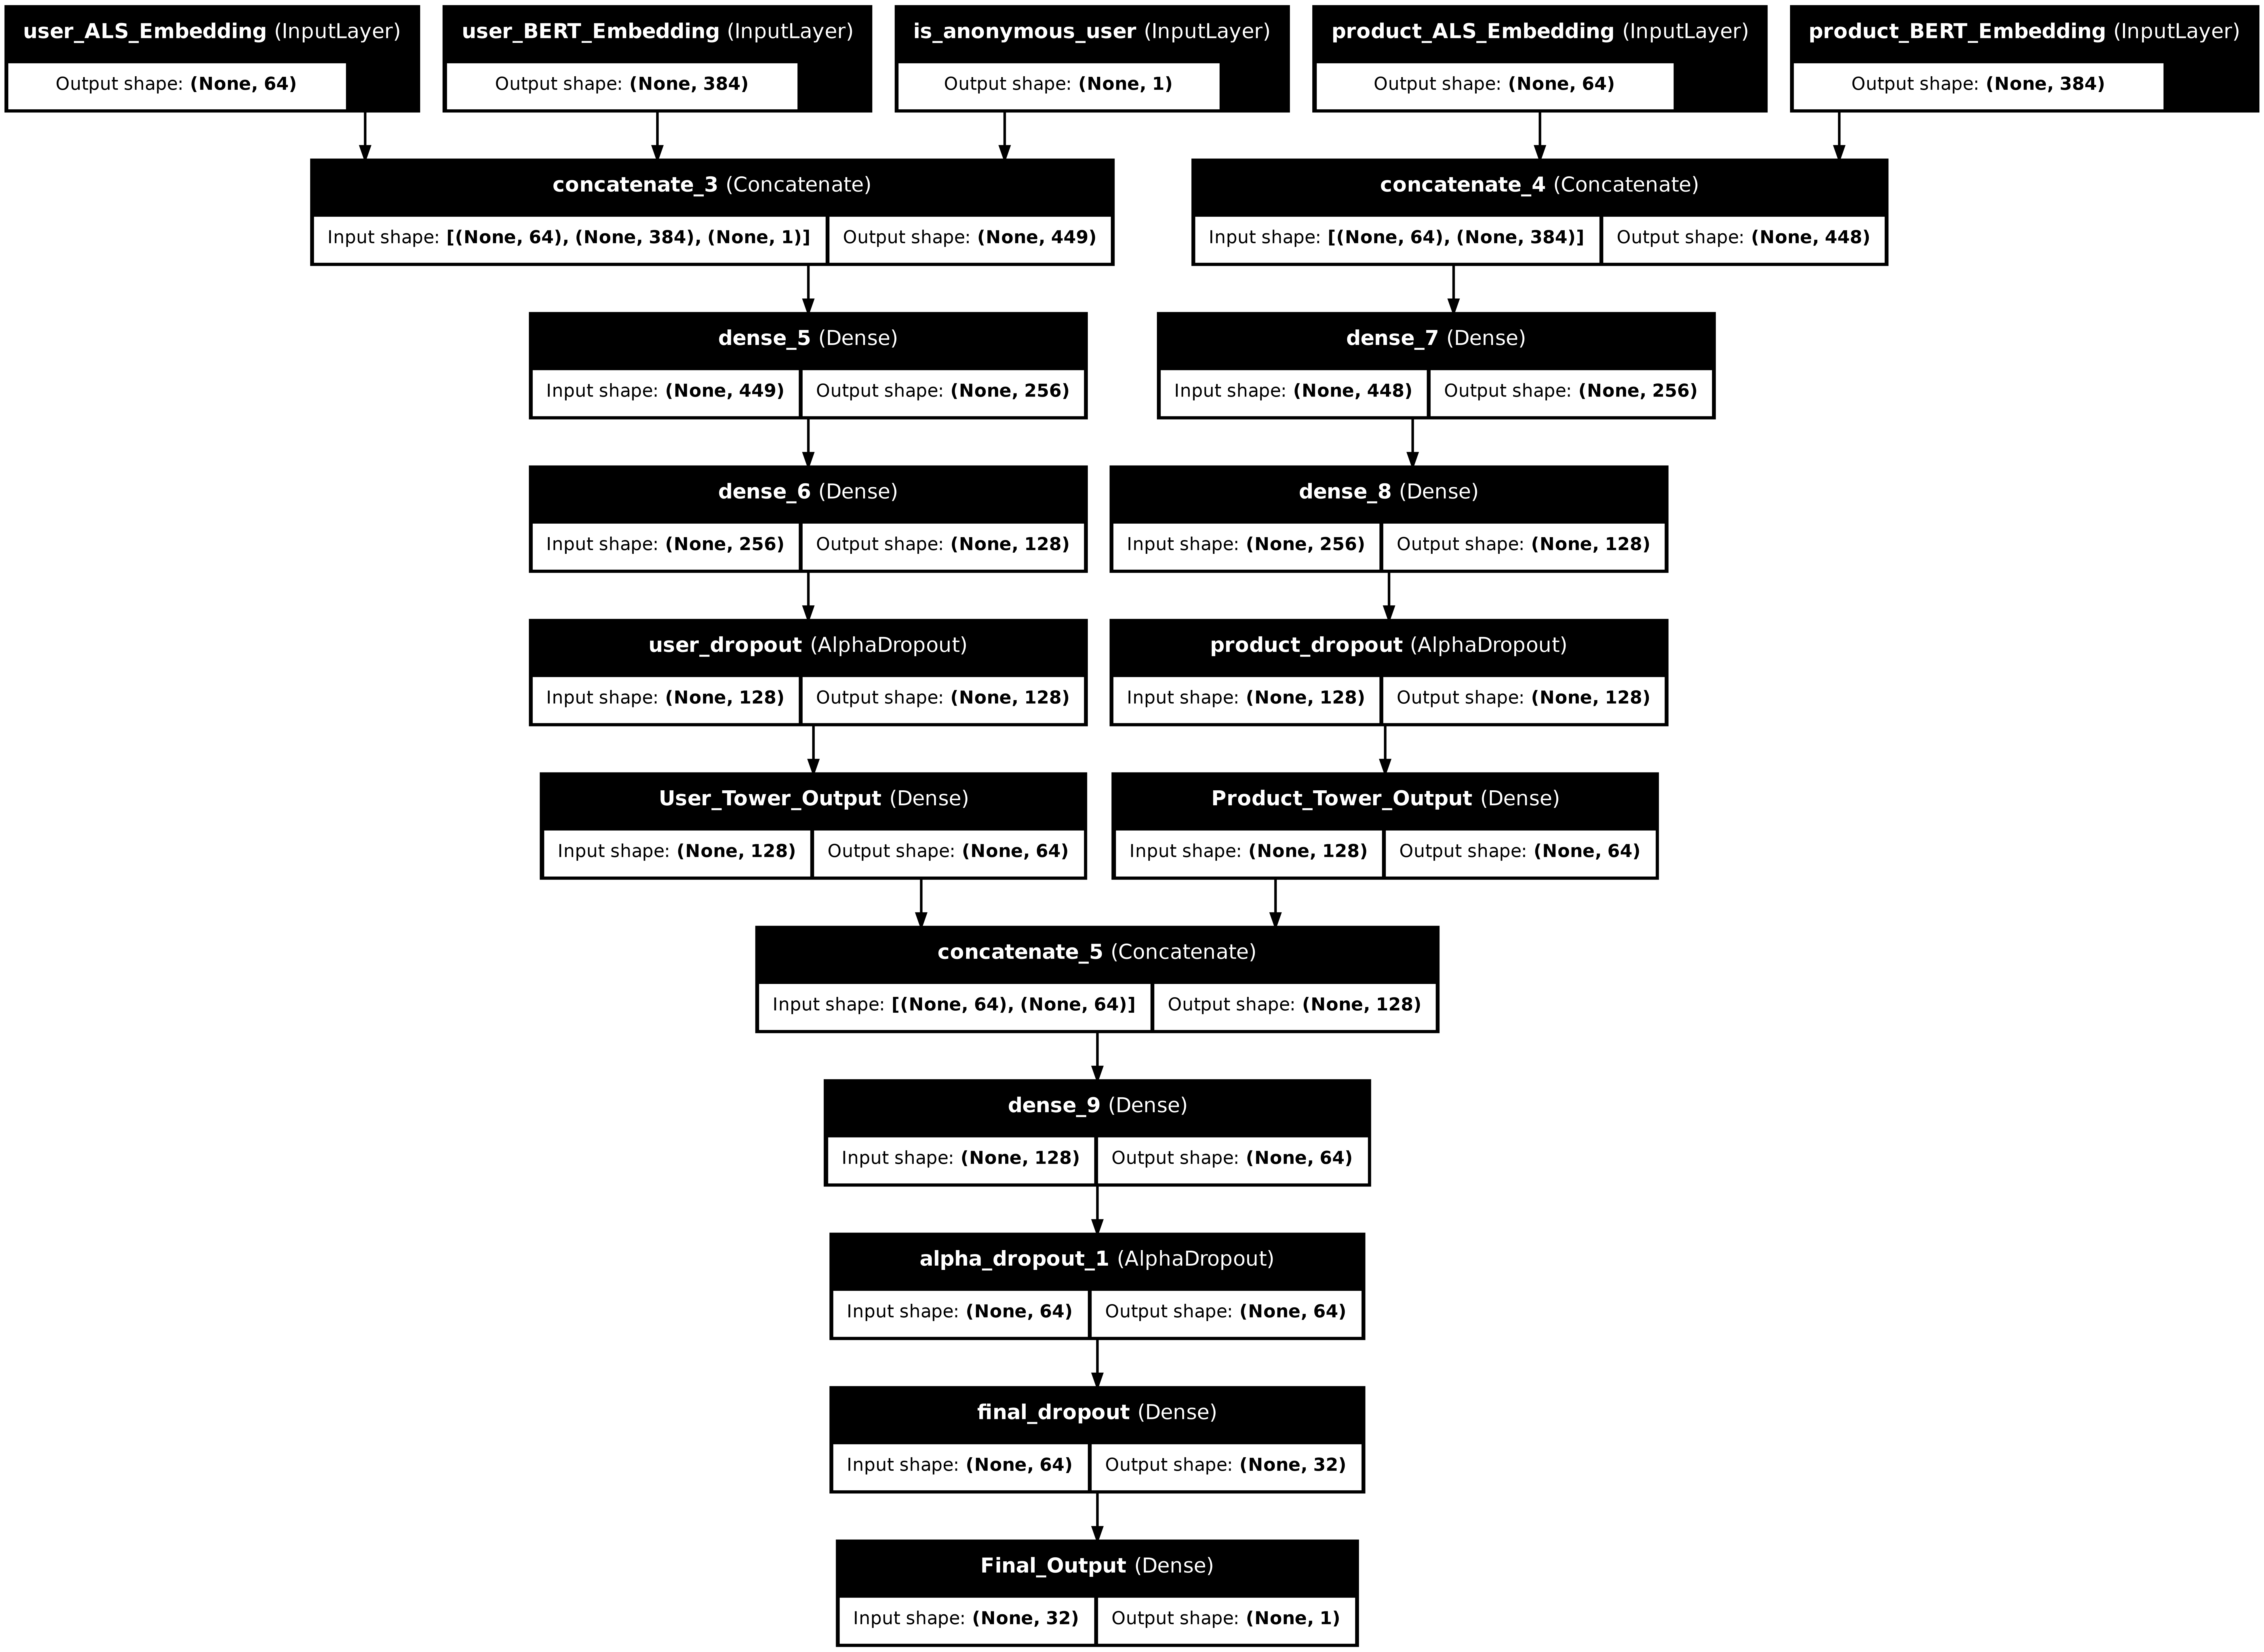

In [108]:
from keras.utils import plot_model

plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=320
)

In [109]:
model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mae'])

In [110]:
# labels = df['reviews.rating'].values.astype('float32')
# labels

In [111]:
history = model.fit(train_dataset, epochs=5)

Epoch 1/5
8881/8881 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - loss: 0.6090 - mae: 0.5920
Epoch 2/5
8881/8881 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.5321 - mae: 0.5643
Epoch 3/5
8881/8881 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.5179 - mae: 0.5579
Epoch 4/5
8881/8881 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.5107 - mae: 0.5553
Epoch 5/5
8881/8881 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.5076 - mae: 0.5539


In [112]:
# Save weights specifically (safer than saving the whole model for subclassed models)
model.save_weights('my_two_tower_model_v6_power.weights.h5')
print("SAFE! Weights saved successfully.")

SAFE! Weights saved successfully.


In [113]:
model.save('two_tower_recsys_v6_power.keras')

In [114]:
df

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,upc,user_id,prod_id,is_negative,review_embeddings,average_mean_review_embeddings,product_embeddings,user_ALS_embedding,product_ALS_embedding,is_anonymous_user
0,AVphSrWZilAPnD_x3onE,Hormel,"Food,Packaged Foods,Packaged Meat & Seafood,Pa...",2015-10-23T05:53:53Z,2018-02-05T11:26:38Z,"376,004,459,550,037,000,000,000","037600351607,037600445955,hormelblacklabelbaco...",Hormel Foods Corp. Meat Products,13220932,"Hormel Black Label Bacon, Original",...,"37,600,351,607,037,600,000,000",44710,485,True,"[-0.04659216, 0.07930003, -0.08208572, 0.11408...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.06107832, 0.000893196, -0.03375268, -0.004...","[-0.090187475, -0.32193705, -0.21443354, -0.34...","[-0.0058443537, -0.0052865148, 0.007902123, 0....",0
1,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",2015-09-11T18:17:13Z,2018-02-05T08:35:02Z,44600015996,"clorox/12992356,044600015996,cloroxdisinfectin...",Clorox,12992356,Clorox Disinfecting Wipes Value Pack Scented 1...,...,44600015996,2549,90,True,"[-0.0415829, -0.049960405, 0.1317048, 0.005613...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05380032, -0.028811436, 0.06277073, -0.087...","[0.13236882, -0.07354266, -0.06986295, 0.54144...","[0.07974092, 0.015135664, 0.04790735, -0.00386...",0
2,AVpgFW3y1cnluZ0-wNXJ,Lionsgate,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",2014-02-21T05:47:43Z,2018-02-05T08:37:18Z,NaN,"lionsgate/13459370,pulpfiction/562879996,lions...",Lions Gate Home Ent.,13459370,Pulp Fiction (dvdvideo),...,31398134626,35942,341,True,"[-0.07018672, -0.01328775, -0.040441707, 0.019...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.06816248, -0.14626448, -0.038818248, -0.03...","[-0.018278796, -0.56499505, 0.9617208, -0.6986...","[0.0067492304, 0.08894772, 0.06478721, -0.0705...",0
3,AVpf63aJLJeJML43F__Q,Burt's Bees,"Personal Care,Makeup,Lipstick, Lip Gloss, & Li...",2017-01-16T15:35:18Z,2018-02-05T11:28:13Z,7.9285E+11,"burtsbeeslipshimmerraisin/b00dx1a5lw,792850371...",Burt's Bees,37199-30,"Burt's Bees Lip Shimmer, Raisin",...,7.9285E+11,2541,99,True,"[-0.015377956, -0.00756643, -0.0009242867, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08888521, -0.13670973, 0.018078422, 0.0377...","[0.44108534, -0.3120291, 0.6991376, -0.195969,...","[0.058231056, 0.059017863, 0.066007696, 0.0466...",0
4,AVpftikC1cnluZ0-p31V,Storkcraft,"Baby,Nursery & Decor,Furniture,Rocking Chairs,...",2015-05-19T01:29:20Z,2018-01-30T06:16:50Z,56927079698,storkcrafttuscanygliderottomanbeigecushionsesp...,1200,06550-549,"Storkcraft Tuscany Glider and Ottoman, Beige C...",...,"56,927,079,704,056,900,000,000",6720,259,True,"[-0.025811749, -0.03337784, 0.08942263, 0.0505...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00033343124, 0.030791266, -0.08060617, 0.0...","[0.90386873, -0.4259539, -0.603969, 0.5411953,...","[0.0011002901, -0.058399156, -0.03138218, 0.11...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284171,AVpfD9xTLJeJML431ig2,FOX,"Movies, Music & Books,Movies,Comedy,Movies & T...",2015-11-09T12:47:55Z,2018-02-05T08:36:37Z,24543168676,"024543168676,fox/52208192,theressomethingabout...",20th Century Fox,52208192,There's Something About Mary (dvd),...,24543168676,11544,136,True,"[-0.0035618134, -0.017193187, 0.0027240678, -0...","[-0.008955281, -0.01695384, 0.0044427486, -0.0...","[-0.03973466, -0.14407419, -0.016431127, -0.04...","[-0.8115288, 0.8358571, -0.21124879, 0.2865741...","[0.0047605895, 0.034349754, -0.05557886, 0.045...",0
284172,AVpfPaoqLJeJML435Xk9,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",2016-07-26T21:32:40Z,2018-02-05T10:22:44Z,NaN,"warnerhomevideo/15773884,883929388448,godzilla...",Test,15773884,Godzilla 3d Includes Digital Copy Ultraviolet ...,...,8.83929E+11,33575,228,True,"[-0.07781814, 0.11972917, -0.05134262, 

In [115]:
""" Make 2 seperate dictionaries for each product id mapping to its bert and als embeddings  """
bert_product_embedding_dict = {}
als_product_embedding_dict = {}

for i in df['prod_id'].unique():
    df_temp = df[df['prod_id'] == i]
    bert_product_embedding_dict[i] = df_temp['product_embeddings'].values[0]
    als_product_embedding_dict[i] = df_temp['product_ALS_embedding'].values[0]

In [116]:
""" A dictionary mapping each product id to its corresponding forward pass through the product tower """
product_tower_forward_pass_embedding_dict = {}
for i in df['prod_id'].unique():
    df_temp = df[df['prod_id'] == i]
    product_als_embedding = df_temp['product_ALS_embedding'].values[0]
    product_bert_embedding = df_temp['product_embeddings'].values[0]
    
    # Create input tensors
    product_als_input = tf.convert_to_tensor([product_als_embedding], dtype=tf.float32)
    product_bert_input = tf.convert_to_tensor([product_bert_embedding], dtype=tf.float32)
    
    # Get the output from the product tower
    product_tower_model = keras.Model(
        inputs=[product_input_1, product_input_2],
        outputs=product_tower_output
    )
    
    product_tower_output_embedding = product_tower_model.predict([product_als_input, product_bert_input])
    product_tower_forward_pass_embedding_dict[i] = product_tower_output_embedding[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [117]:
product_tower_forward_pass_embedding_dict #precomputed product tower embeddings for each product id

{np.int64(485): array([-1.7580707, -1.7573546, -1.7580645, -1.7580993, 10.830092 ,
         2.0628095, -1.7579174, 43.359768 , -1.758099 , -1.7580993,
        -1.7580582, -1.7580993, -1.7567219, -1.7505559, -1.7469431,
        -1.6502585, -1.7580993,  0.2618204, -1.7580872, -1.7580993,
        -1.749402 , -1.7579423, -1.7580993, -1.75651  , -1.7580993,
        -1.758092 , -1.6903062, -1.7580992,  7.383228 ,  8.2019205,
        31.105257 , -1.7580993, -1.7580993, -1.7580992,  1.1896377,
        -1.7578694, -1.7580993,  1.1827886,  5.973648 , -1.6924708,
        24.381493 , -1.747562 , -1.706606 , -1.7580993, -1.7580993,
        16.235754 , -1.7580991, -1.7580867, -1.7577447,  2.2137446,
        -1.7580988, 30.885912 , -0.7112621, 31.040499 , -1.6210189,
        -1.7580892, -1.7580993, -1.7580993, -1.7580993, -1.7580993,
        -1.7166375, -1.7580992, -1.7580993, -1.7577151], dtype=float32),
 np.int64(90): array([-1.7542646 , -1.7580993 , 13.560106  , -1.7580938 , -1.7580965 ,
        -

In [120]:
""" Now we will take a list of user_ids and product_ids and then recommend top k products for each user based on concatenating precomputed product tower embeddings and user tower embeddings and then passing through final dense layers to get the predicted rating and then recommending top k products with highest predicted ratings for each user  """
""" Also since ALS embeddings are same for each user BERT embeddings differ , so we will use the last BERT embedding of the user as user embedding and then concatenate with product tower embedding and then pass through final dense layers to get predicted rating for that product and then recommend top k products with highest predicted ratings for each user  """

import numpy as np

def predict_for_users_batched(user_ids, top_k=5, product_ids=None):
    if product_ids is None:
        product_ids = df['prod_id'].unique()
    
    recommendations = {}
    
    model_to_use = keras.Model(
        inputs=[user_input_1, user_input_2, user_input_3, product_input_1, product_input_2],
        outputs=final_output
    )

    # Pre-bundle Product Embeddings
    p_als_matrix = np.array([als_product_embedding_dict[p] for p in product_ids])
    p_bert_matrix = np.array([bert_product_embedding_dict[p] for p in product_ids])
    num_products = len(product_ids)

    for user_id in user_ids:
        # Get the last review row for this user
        user_rows = df[df['user_id'] == user_id]
        user_data = user_rows.iloc[-1]
        
        # Tile User Data
        u_als_batch = np.tile(user_data['user_ALS_embedding'], (num_products, 1))
        u_bert_batch = np.tile(user_data['average_mean_review_embeddings'], (num_products, 1))
        u_anon_batch = np.tile([user_data['is_anonymous_user']], (num_products, 1))

        # Single Batch Prediction
        predicted_ratings = model_to_use.predict(
            [u_als_batch, u_bert_batch, u_anon_batch, p_als_matrix, p_bert_matrix],
            batch_size=1024, # Higher batch size is usually faster for inference
        )

        scores = predicted_ratings.flatten()
        top_indices = np.argsort(scores)[-top_k:][::-1]
        
        # Map indices back to product IDs
        recommendations[user_id] = [(product_ids[i], scores[i]) for i in top_indices]

    return recommendations

In [123]:
predict_for_users_batched([0,1,2,3,4,5], top_k=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


{0: [(np.int64(90), np.float32(5.2486887)),
  (np.int64(183), np.float32(5.2436037)),
  (np.int64(381), np.float32(5.2435904))],
 1: [(np.int64(551), np.float32(0.99319416)),
  (np.int64(102), np.float32(0.99319416)),
  (np.int64(278), np.float32(0.99319416))],
 2: [(np.int64(381), np.float32(5.233424)),
  (np.int64(90), np.float32(5.2314405)),
  (np.int64(183), np.float32(5.227625))],
 3: [(np.int64(204), np.float32(0.99811506)),
  (np.int64(514), np.float32(0.99319416)),
  (np.int64(490), np.float32(0.99319416))],
 4: [(np.int64(551), np.float32(0.99319416)),
  (np.int64(102), np.float32(0.99319416)),
  (np.int64(278), np.float32(0.99319416))],
 5: [(np.int64(551), np.float32(0.99319416)),
  (np.int64(102), np.float32(0.99319416)),
  (np.int64(278), np.float32(0.99319416))]}

In [125]:
df['prod_id'].value_counts().head(10)

prod_id
90     31817
380    21428
575    14303
426    13893
228    13307
455    10949
310    10042
474     9279
270     9144
183     8698
Name: count, dtype: int64

In [121]:
df['reviews.rating'].describe()

count    2.841760e+05
mean     1.846288e+00
std      1.638653e+00
min      1.646768e-07
25%      6.657402e-01
50%      1.299114e+00
75%      1.965397e+00
max      5.000000e+00
Name: reviews.rating, dtype: float64